# Sentiment analysis: *Amazon fine food review* - 2nd part

For this notebook, I heavily used this article: [here](https://medium.com/nerd-for-tech/fine-tuning-pretrained-bert-for-sentiment-classification-using-transformers-in-python-931ed142e37)

### Presentation

* The project is based on the Amazon food review from customers dataset
* The original Kaggle competition was to predict whether a review was positive or negative
* In this project, we will add the **neural** level
* You will try to **predict the 3 classes** given by the user according to their **review**
* The dataset contains more than 500K reviews

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 40.0 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 17.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import re
from pathlib import Path


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import (
    metrics,
    model_selection,
)

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
DATA = Path("drive/My Drive/data")

assert DATA.is_dir()

IMG = Path("drive/My Drive/img")

assert IMG.is_dir()

RES = Path("drive/My Drive/res")

assert RES.is_dir()

### Read Data

In [6]:
raw_df = pd.read_csv(DATA / "Reviews_small.csv.xz")
raw_df.head()

raw_dim = raw_df.shape[0]
df = raw_df[~raw_df.duplicated(["Text", "Summary"])].copy()
dim = df.shape[0]

print(f"{dim / raw_dim:.2%}, raw_dim: {raw_dim:,}, dim: {dim:,}")

#df = raw_df[~raw_df.duplicated(["Text", "Summary", "Score"])]
#df[df.duplicated(["Text", "Summary"], keep=False)].shape[0]

100.00%, raw_dim: 394,970, dim: 394,970


* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

### Data exploration


#### Distribution of the variable ***Score***

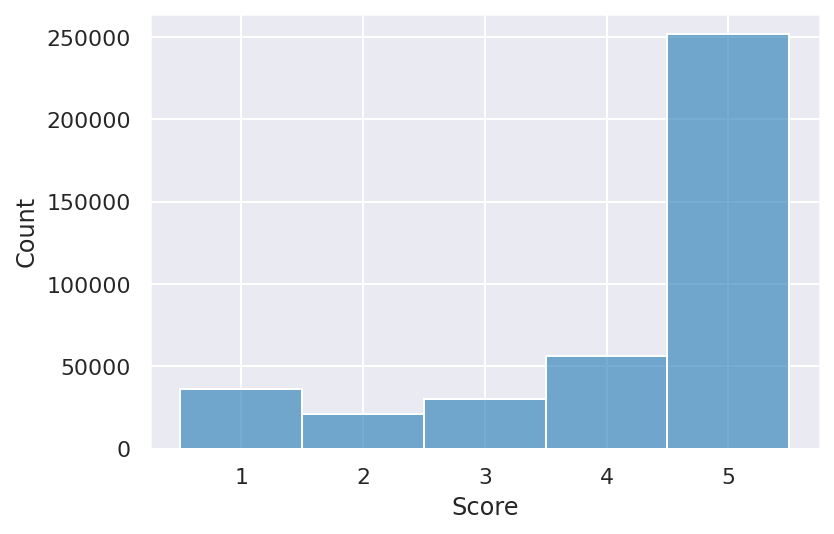

In [7]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()

* Most of the customer rating is positive 

### Analysis of binary and 3-classes versions

* Convert the 5-grade rating to a 3-grade sentiment as a target variable
* Positive ratings will be classified as +1, neutral 0, and negative -1
* The value of 3 in the rating will be used as threshold

In [8]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 2
    if rating < threshold:
        return 0
    return 1

In [9]:
df["sentiment"] = df.Score.map(convert_rating)

We had to change the value here as we fed our data to BERT that need this encoding. As there are 3 classes, labels are 0, 1 and 2.

## Create the train and test sets

It is **crucial** to keep the **test set** for the very last check when the model has been built.

In [10]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

In [11]:
train_df.shape, train_df.shape[0]//2

((315976, 5), 157988)

### Preparation

In [12]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

The class we will need to encode our data (with DataLoader) to BERT for fine-tuning or testing.

## Classification based on `Summary`

In [13]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

cln_test_df = test_df[["Summary", "sentiment"]].copy()
cln_test_df.dropna(subset=["Summary"], inplace=True)

Split the data into a train (80%) and validation sets (20%)

In [14]:
text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Summary, cln_df.sentiment, test_size=0.2, random_state=1
)
print(text_train.shape)
text_train = text_train[:text_train.shape[0]//2]
y_train = y_train[:y_train.shape[0]//2]
assert text_train.shape == y_train.shape

(252780,)


> Due to computing time, I used half of the training set for training.

In [15]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)
train_encodings = tokenizer(text_train.values.tolist(), truncation=True, padding=True,return_tensors = 'pt') # Tokenize the summaries
valid_encodings = tokenizer(text_valid.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(cln_test_df["Summary"].values.tolist(),truncation=True, padding=True,return_tensors = 'pt')

train_dataset = SentimentDataset(train_encodings, y_train.values.tolist())
valid_dataset = SentimentDataset(valid_encodings, y_valid.values.tolist())
test_dataset = SentimentDataset(test_encodings,cln_test_df["sentiment"].values.tolist())

In [16]:
training_args = TrainingArguments(
    output_dir=RES / "m1",          # output directory
    evaluation_strategy="steps",
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    #logging_steps=10,
    load_best_model_at_end=True,
)

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

In [17]:
import warnings
warnings.filterwarnings('ignore')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=3)
model = model.to(device)

trainer = Trainer(
    model=model,# the instantiated 🤗 Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=train_dataset,# training dataset
    eval_dataset=valid_dataset , # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.500100,0.353636,0.871271,0.856217
1000,0.361800,0.341152,0.876145,0.864513
1500,0.341400,0.324620,0.882538,0.867999


***** Running Evaluation *****
  Num examples = 63195
  Batch size = 128
Saving model checkpoint to drive/My Drive/res/m1/checkpoint-500
Configuration saved in drive/My Drive/M1/res/m1/checkpoint-500/config.json
Model weights saved in drive/My Drive/M1/res/m1/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 63195
  Batch size = 128
Saving model checkpoint to drive/My Drive/res/m1/checkpoint-1000
Configuration saved in drive/My Drive/res/m1/checkpoint-1000/config.json
Model weights saved in drive/My Drive/res/m1/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 63195
  Batch size = 128
Saving model checkpoint to drive/My Drive/res/m1/checkpoint-1500
Configuration saved in drive/My Drive/res/m1/checkpoint-1500/config.json
Model weights saved in drive/My Drive/res/m1/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/My Drive/re

TrainOutput(global_step=1975, training_loss=0.38398104510729825, metrics={'train_runtime': 2385.8542, 'train_samples_per_second': 52.975, 'train_steps_per_second': 0.828, 'total_flos': 2550669026316840.0, 'train_loss': 0.38398104510729825, 'epoch': 1.0})

***** Running Prediction *****
  Num examples = 78992
  Batch size = 128


              precision    recall  f1-score   support

           0     0.7156    0.7672    0.7405     11591
           1     0.5840    0.1990    0.2969      5954
           2     0.9200    0.9662    0.9425     61447

    accuracy                         0.8792     78992
   macro avg     0.7399    0.6442    0.6600     78992
weighted avg     0.8647    0.8792    0.8642     78992



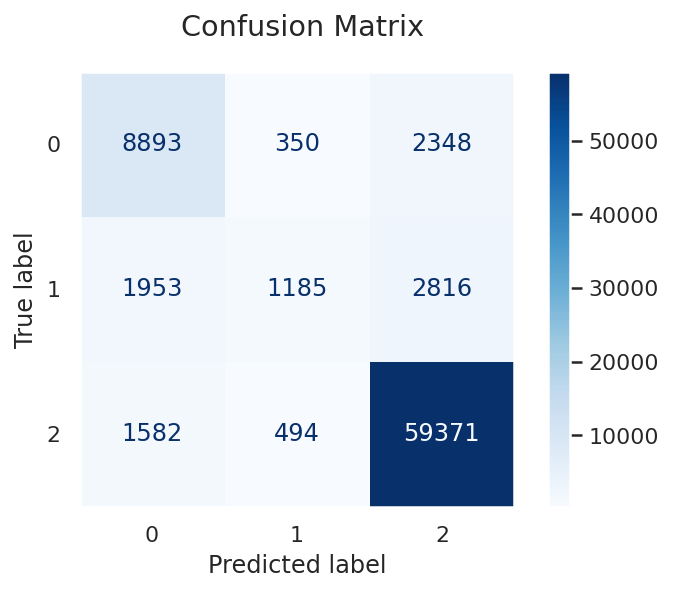

In [18]:
preds = trainer.predict(test_dataset=test_dataset)

probs = torch.from_numpy(preds[0]).softmax(1) # Retrieving the probabilities

predictions = np.argmax(probs.numpy(),axis=1)

print(metrics.classification_report(cln_test_df["sentiment"].values,predictions,digits=4))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    cln_test_df["sentiment"].values,predictions, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

> For the first time, we have quite good result despite not fine-tuning that much BERT.
The parameters used to fine-tune were :
```
num_train_epochs=3,              
per_device_train_batch_size=32, 
per_device_eval_batch_size=64,
```
However, I cancelled the training at the middle of the first iteration and saved the parameters. The reason I did that is:
* It would be too long to do all the training.
* We had good results.

> In this version, I reduced the number of epoch for the training and increased the last 2 parameters.

> Despite using ```Summary```  that contains a few data, we have pretty good result. The usage of some kind of words would help a lot when classifying.
The class 1 is often misclassified compared to the 2 others. It might be because those summaries, unlike the 2 other classes, use a neutral vocabulary. Hence, the bad result, which is not that unexpected. Maybe the use of ```Text``` will yield better result.

## Baseline Model with `Text` Reviews

In [19]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

cln_test_df = test_df[["Text", "sentiment"]].copy()
cln_test_df.dropna(subset=["Text"], inplace=True)
cln_test_df = cln_test_df.head(cln_test_df.shape[0]//20)

Split the data into train (80%) and validation sets (20%)

In [20]:
text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)
text_train = text_train[:text_train.shape[0]//40]
y_train = y_train[:y_train.shape[0]//40]
assert text_train.shape == y_train.shape
cln_test_df.shape,y_train.shape

((3949, 2), (6319,))

Due to computing time, I used a very low amount of data for training.
What I want to see is what results BERT will give with lightly fine-tuned parameters.
Then, it will be interesting to see how BERT do with:
* more data
* longer training

In [21]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)
train_encodings = tokenizer(text_train.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')
valid_encodings = tokenizer(text_valid.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(cln_test_df["Text"].values.tolist(),truncation=True, padding=True,return_tensors = 'pt')

train_dataset = SentimentDataset(train_encodings, y_train.values.tolist())
valid_dataset = SentimentDataset(valid_encodings, y_valid.values.tolist())
test_dataset = SentimentDataset(test_encodings,cln_test_df["sentiment"].values.tolist())

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accef

In [22]:
training_args = TrainingArguments(
    output_dir=RES / "m2",    
    evaluation_strategy="steps",
    num_train_epochs=1,          
    per_device_train_batch_size=12,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,               
    weight_decay=0.01,            
    logging_dir='./logs4',          
    #logging_steps=10,
    load_best_model_at_end=True,
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
import gc
model = None
gc.collect()
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=3)
model = model.to(device)

trainer = Trainer(
    model=model,
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=valid_dataset , 
    compute_metrics=compute_metrics,
)
trainer.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-b

Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.524300,0.456651,0.822489,0.823388


***** Running Evaluation *****
  Num examples = 63196
  Batch size = 64
Saving model checkpoint to drive/My Drive//res/m2/checkpoint-500
Configuration saved in drive/My Drive/res/m2/checkpoint-500/config.json
Model weights saved in drive/My Drive/res/m2/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/My Drive/res/m2/checkpoint-500 (score: 0.4566509425640106).


TrainOutput(global_step=527, training_loss=0.5189692499063047, metrics={'train_runtime': 2604.407, 'train_samples_per_second': 2.426, 'train_steps_per_second': 0.202, 'total_flos': 837076419910656.0, 'train_loss': 0.5189692499063047, 'epoch': 1.0})

> Here, I end up with lower result than before. It was excepted as I used less data for training. But we still got good results.

Let's see our result on the (reduced) test set:

***** Running Prediction *****
  Num examples = 3949
  Batch size = 64


              precision    recall  f1-score   support

           0     0.5537    0.8433    0.6685       587
           1     0.2679    0.1772    0.2133       316
           2     0.9396    0.8779    0.9077      3046

    accuracy                         0.8167      3949
   macro avg     0.5871    0.6328    0.5965      3949
weighted avg     0.8285    0.8167    0.8166      3949



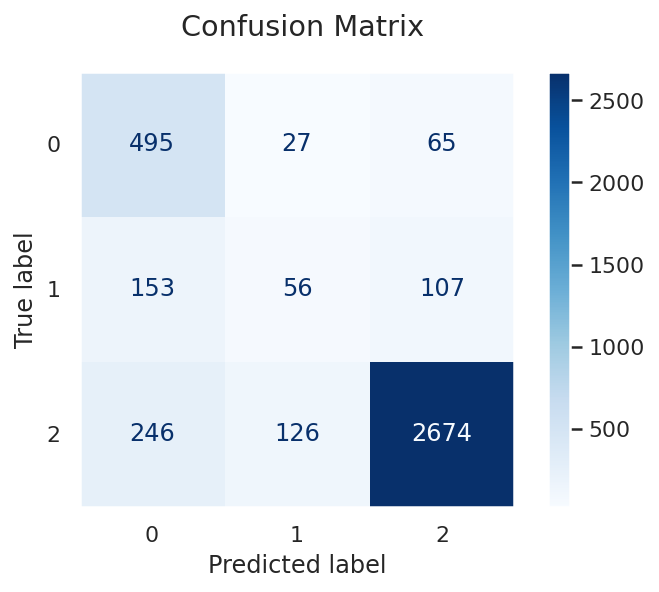

In [24]:
preds = trainer.predict(test_dataset=test_dataset)

probs = torch.from_numpy(preds[0]).softmax(1)

predictions = np.argmax(probs.numpy(),axis=1)

print(metrics.classification_report(cln_test_df["sentiment"].values,predictions,digits=4))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    cln_test_df["sentiment"].values,predictions, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

Results are good but the size of the data is too low to draw a definite conclusion.

I am going to do a longer training to avoid the notebook crashing with too much data.

In [25]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

cln_test_df = test_df[["Text", "sentiment"]].copy()
cln_test_df.dropna(subset=["Text"], inplace=True)
cln_test_df = cln_test_df.head(cln_test_df.shape[0]//20)

text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)
text_train = text_train[:text_train.shape[0]//40]
y_train = y_train[:y_train.shape[0]//40]
assert text_train.shape == y_train.shape

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)
train_encodings = tokenizer(text_train.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')
valid_encodings = tokenizer(text_valid.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(cln_test_df["Text"].values.tolist(),truncation=True, padding=True,return_tensors = 'pt')

train_dataset = SentimentDataset(train_encodings, y_train.values.tolist())
valid_dataset = SentimentDataset(valid_encodings, y_valid.values.tolist())
test_dataset = SentimentDataset(test_encodings,cln_test_df["sentiment"].values.tolist())

training_args = TrainingArguments(
    output_dir=RES / "m3",   
    evaluation_strategy="steps",
    num_train_epochs=2,    
    per_device_train_batch_size=12, 
    per_device_eval_batch_size=12,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs4',            
    #logging_steps=10,
    load_best_model_at_end=True,
)

cln_test_df.shape,y_train.shape

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accef

((3949, 2), (6319,))

In [26]:
model = None
gc.collect()
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=3)
model = model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset ,
    compute_metrics=compute_metrics,
)
trainer.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-b

Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.545100,0.436983,0.843740,0.834553
1000,0.325000,0.351732,0.877587,0.866538


***** Running Evaluation *****
  Num examples = 63196
  Batch size = 12
Saving model checkpoint to drive/My Drive/res/m3/checkpoint-500
Configuration saved in drive/My Drive/res/m3/checkpoint-500/config.json
Model weights saved in drive/My Drive/res/m3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 63196
  Batch size = 12
Saving model checkpoint to drive/My Drive/res/m3/checkpoint-1000
Configuration saved in drive/My Drive/res/m3/checkpoint-1000/config.json
Model weights saved in drive/My Drive/res/m3/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/My Drive/res/m3/checkpoint-1000 (score: 0.3517323136329651).


TrainOutput(global_step=1054, training_loss=0.4266510263113641, metrics={'train_runtime': 5270.8806, 'train_samples_per_second': 2.398, 'train_steps_per_second': 0.2, 'total_flos': 1674152839821312.0, 'train_loss': 0.4266510263113641, 'epoch': 2.0})

***** Running Prediction *****
  Num examples = 3949
  Batch size = 12


              precision    recall  f1-score   support

           0     0.7430    0.7632    0.7529       587
           1     0.4722    0.2690    0.3427       316
           2     0.9232    0.9596    0.9411      3046

    accuracy                         0.8752      3949
   macro avg     0.7128    0.6639    0.6789      3949
weighted avg     0.8604    0.8752    0.8652      3949



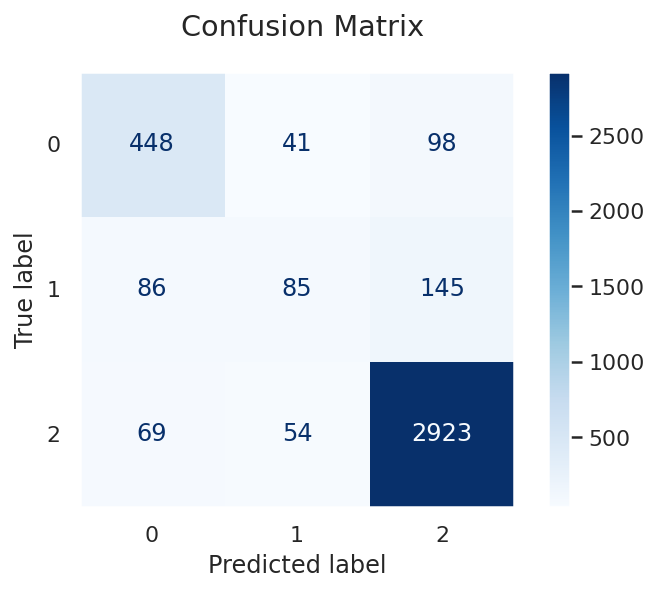

In [27]:
preds = trainer.predict(test_dataset=test_dataset)

probs = torch.from_numpy(preds[0]).softmax(1)

predictions = np.argmax(probs.numpy(),axis=1)

print(metrics.classification_report(cln_test_df["sentiment"].values,predictions,digits=4))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    cln_test_df["sentiment"].values,predictions, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

> There are improvements compared to the first part.
Using the whole dataset would give better results.